통계적 근거 기반 데이터 변환 실습
- Box-Cox 변환을 통한 정규성 개선
- Yeo-Johnson 변환 (음수 값 포함)
- 로그 변환과 제곱근 변환의 통계적 근거
- 변환 효과 검증

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('default')

1. 다양한 분포를 가진 시뮬레이션 데이터 생성

In [2]:
# 우편향 분포 (제조 공정의 처리 시간)
processing_time = np.random.exponential(2, 1000) + 1

# 좌편향 분포 (품질 점수 - 대부분 높은 점수)
quality_score = 100 - np.random.exponential(5, 1000)
quality_score = quality_score[quality_score > 0]  # 양수만 유지

# 이분형 분포 (온도 데이터 - 두 개의 공정 모드)  
temp_mode1 = np.random.normal(70, 3, 500)
temp_mode2 = np.random.normal(85, 4, 500)
bimodal_temp = np.concatenate([temp_mode1, temp_mode2])

# 중간에 0이 포함된 데이터 (압력 변화량)
pressure_change = np.random.normal(0, 5, 1000)

# 데이터프레임 생성
df = pd.DataFrame({
    'processing_time': processing_time,
    'quality_score': quality_score[:1000] if len(quality_score) >= 1000 else 
                    np.pad(quality_score, (0, 1000-len(quality_score)), mode='edge'),
    'bimodal_temp': bimodal_temp,
    'pressure_change': pressure_change
})

print("=== 다양한 분포 특성을 가진 데이터 ===")
print(f"데이터 크기: {df.shape}")
print("\n기초 통계:")
print(df.describe())


=== 다양한 분포 특성을 가진 데이터 ===
데이터 크기: (1000, 4)

기초 통계:
       processing_time  quality_score  bimodal_temp  pressure_change
count      1000.000000    1000.000000   1000.000000      1000.000000
mean          2.973800      95.051857     77.631520         0.049240
std           2.001472       5.096334      8.374945         5.095550
min           1.001293      60.081339     61.350070       -16.919122
25%           1.584882      93.250879     70.003517        -3.423654
50%           2.351911      96.575024     76.646869        -0.126017
75%           3.614747      98.704773     84.987121         3.787042
max          13.999617      99.990738     99.485505        15.886464


2. 정규성 검정 함수

In [3]:
def test_normality(data, name):
    """정규성 검정 및 결과 출력"""
    # Shapiro-Wilk Test (샘플 크기 5000 이하)
    if len(data) <= 5000:
        stat_sw, p_sw = stats.shapiro(data)
        print(f"\n{name} - Shapiro-Wilk Test:")
        print(f"  통계량: {stat_sw:.4f}, p-value: {p_sw:.6f}")
        if p_sw > 0.05:
            print("  → 정규분포를 따른다고 볼 수 있음")
        else:
            print("  → 정규분포를 따르지 않음")
    
    # Kolmogorov-Smirnov Test
    stat_ks, p_ks = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
    print(f"\n{name} - Kolmogorov-Smirnov Test:")
    print(f"  통계량: {stat_ks:.4f}, p-value: {p_ks:.6f}")
    
    # 왜도와 첨도
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    print(f"\n{name} - 분포 특성:")
    print(f"  왜도(Skewness): {skewness:.4f}")
    if abs(skewness) < 0.5:
        print("    → 대칭적 분포")
    elif skewness > 0.5:
        print("    → 우편향 분포 (꼬리가 오른쪽으로)")
    else:
        print("    → 좌편향 분포 (꼬리가 왼쪽으로)")
    
    print(f"  첨도(Kurtosis): {kurtosis:.4f}")
    if abs(kurtosis) < 0.5:
        print("    → 정규분포와 유사한 첨도")
    elif kurtosis > 0.5:
        print("    → 뾰족한 분포 (정규분포보다)")
    else:
        print("    → 평평한 분포 (정규분포보다)")

3. 원본 데이터 정규성 검정

In [11]:
print("=== 원본 데이터 정규성 검정 ===")
test_normality(df['processing_time'], "Processing Time")
test_normality(df['quality_score'], "Quality Score")

=== 원본 데이터 정규성 검정 ===

Processing Time - Shapiro-Wilk Test:
  통계량: 0.8053, p-value: 0.000000
  → 정규분포를 따르지 않음

Processing Time - Kolmogorov-Smirnov Test:
  통계량: 0.1621, p-value: 0.000000

Processing Time - 분포 특성:
  왜도(Skewness): 1.9908
    → 우편향 분포 (꼬리가 오른쪽으로)
  첨도(Kurtosis): 5.1112
    → 뾰족한 분포 (정규분포보다)

Quality Score - Shapiro-Wilk Test:
  통계량: 0.8000, p-value: 0.000000
  → 정규분포를 따르지 않음

Quality Score - Kolmogorov-Smirnov Test:
  통계량: 0.1661, p-value: 0.000000

Quality Score - 분포 특성:
  왜도(Skewness): -2.1399
    → 좌편향 분포 (꼬리가 왼쪽으로)
  첨도(Kurtosis): 6.6921
    → 뾰족한 분포 (정규분포보다)


4. Box-Cox 변환

In [5]:
def apply_boxcox_transform(data, name):
    """Box-Cox 변환 적용 및 결과 분석"""
    print(f"\n=== {name} Box-Cox 변환 ===")
    
    # 데이터가 양수인지 확인
    if np.min(data) <= 0:
        print("경고: Box-Cox 변환은 양수 데이터에만 적용 가능")
        print(f"최소값: {np.min(data):.4f}")
        # 상수 더하기로 양수 만들기
        data_positive = data - np.min(data) + 1
        print(f"변환 후 최소값: {np.min(data_positive):.4f}")
        data = data_positive
    
    # Box-Cox 변환
    transformed_data, lambda_opt = boxcox(data)
    
    print(f"최적 λ (lambda): {lambda_opt:.4f}")
    
    # λ 값의 의미 해석
    if abs(lambda_opt) < 0.1:
        print("  → λ ≈ 0: 로그 변환과 유사")
    elif abs(lambda_opt - 0.5) < 0.1:
        print("  → λ ≈ 0.5: 제곱근 변환과 유사")
    elif abs(lambda_opt - 1) < 0.1:
        print("  → λ ≈ 1: 변환 불필요 (원본과 동일)")
    elif abs(lambda_opt - 2) < 0.1:
        print("  → λ ≈ 2: 제곱 변환")
    elif lambda_opt < 0:
        print("  → λ < 0: 역변환 계열")
    
    return transformed_data, lambda_opt

In [6]:
# Processing Time Box-Cox 변환
pt_transformed, pt_lambda = apply_boxcox_transform(df['processing_time'], 
                                                 "Processing Time")


=== Processing Time Box-Cox 변환 ===
최적 λ (lambda): -0.4034
  → λ < 0: 역변환 계열


5. Yeo-Johnson 변환 (음수 값 포함 가능)

In [7]:
def apply_yeojohnson_transform(data, name):
    """Yeo-Johnson 변환 적용"""
    print(f"\n=== {name} Yeo-Johnson 변환 ===")
    
    transformed_data, lambda_opt = yeojohnson(data)
    
    print(f"최적 λ (lambda): {lambda_opt:.4f}")
    print("Yeo-Johnson 변환의 장점: 음수 값도 처리 가능")
    
    return transformed_data, lambda_opt

# Pressure Change Yeo-Johnson 변환
pc_transformed, pc_lambda = apply_yeojohnson_transform(df['pressure_change'], 
                                                     "Pressure Change")



=== Pressure Change Yeo-Johnson 변환 ===
최적 λ (lambda): 0.9870
Yeo-Johnson 변환의 장점: 음수 값도 처리 가능


6. 로그 변환의 통계적 근거

In [8]:
def log_transformation_analysis(data, name):
    """로그 변환의 효과 분석"""
    print(f"\n=== {name} 로그 변환 분석 ===")
    
    if np.min(data) <= 0:
        print("경고: 로그 변환을 위해 상수 추가")
        data = data - np.min(data) + 1
    
    log_data = np.log(data)
    
    print("로그 변환 전후 비교:")
    print(f"  원본 왜도: {stats.skew(data):.4f}")
    print(f"  로그 변환 후 왜도: {stats.skew(log_data):.4f}")
    print(f"  왜도 개선: {abs(stats.skew(data)) - abs(stats.skew(log_data)):.4f}")
    
    return log_data

In [9]:
# Processing Time 로그 변환
pt_log = log_transformation_analysis(df['processing_time'], "Processing Time")


=== Processing Time 로그 변환 분석 ===
로그 변환 전후 비교:
  원본 왜도: 1.9908
  로그 변환 후 왜도: 0.4914
  왜도 개선: 1.4994


7. 시각화

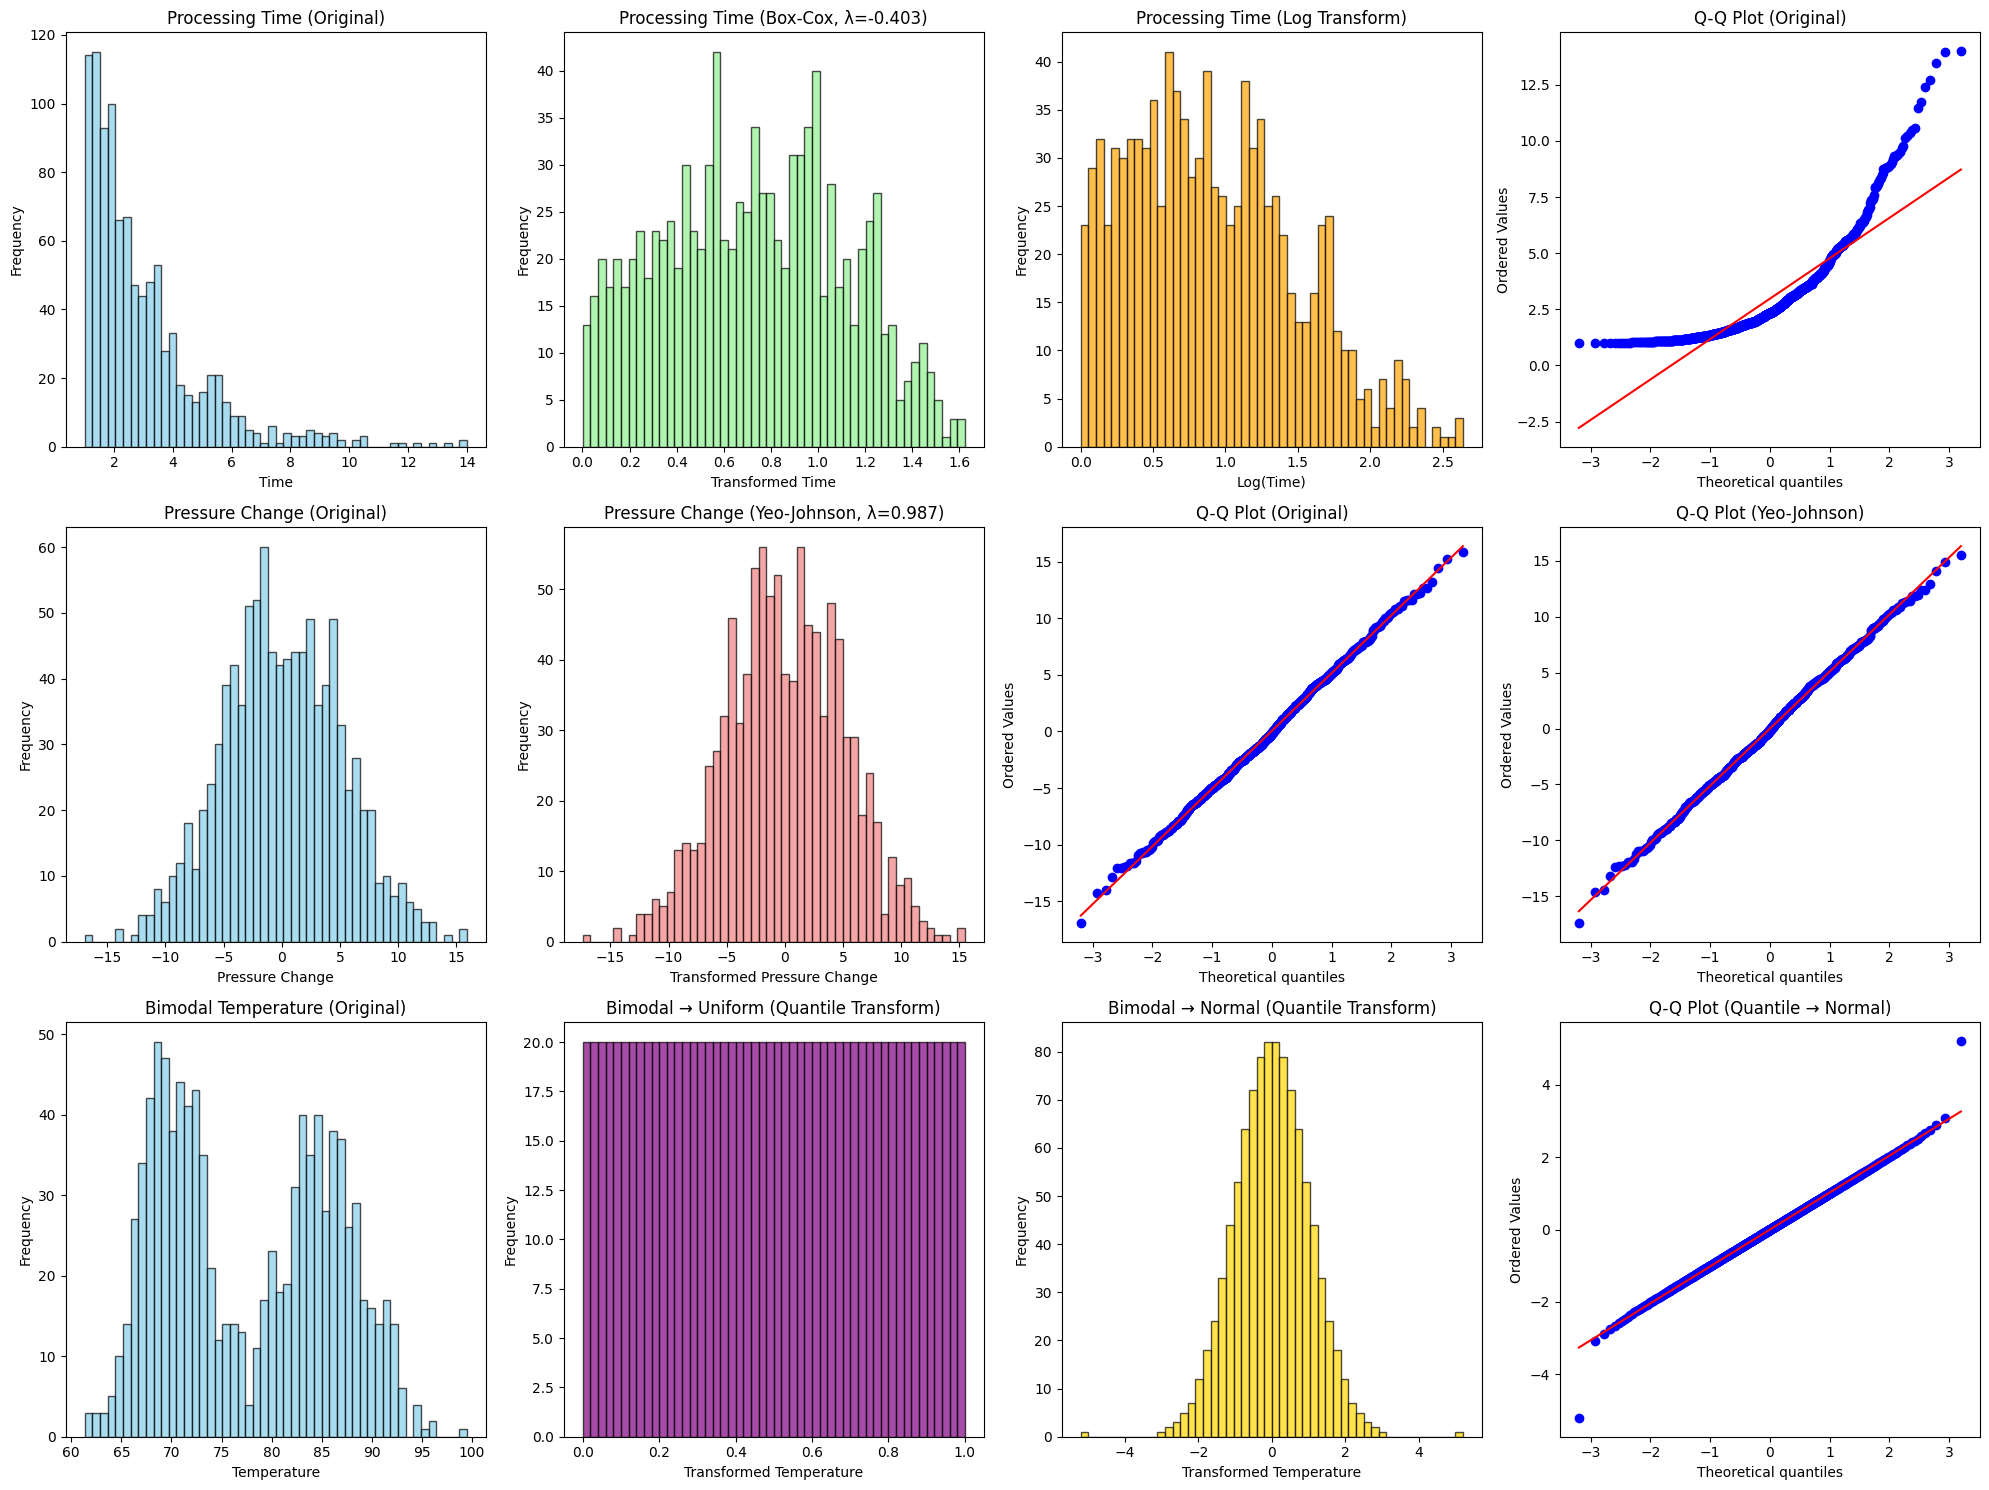

In [10]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Processing Time 원본 vs 변환
axes[0,0].hist(df['processing_time'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Processing Time (Original)')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Frequency')

axes[0,1].hist(pt_transformed, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title(f'Processing Time (Box-Cox, λ={pt_lambda:.3f})')
axes[0,1].set_xlabel('Transformed Time')
axes[0,1].set_ylabel('Frequency')

axes[0,2].hist(pt_log, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0,2].set_title('Processing Time (Log Transform)')
axes[0,2].set_xlabel('Log(Time)')
axes[0,2].set_ylabel('Frequency')

# Q-Q Plot으로 정규성 비교
stats.probplot(df['processing_time'], dist="norm", plot=axes[0,3])
axes[0,3].set_title('Q-Q Plot (Original)')

# Pressure Change 원본 vs 변환
axes[1,0].hist(df['pressure_change'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,0].set_title('Pressure Change (Original)')
axes[1,0].set_xlabel('Pressure Change')
axes[1,0].set_ylabel('Frequency')

axes[1,1].hist(pc_transformed, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,1].set_title(f'Pressure Change (Yeo-Johnson, λ={pc_lambda:.3f})')
axes[1,1].set_xlabel('Transformed Pressure Change')
axes[1,1].set_ylabel('Frequency')

# Q-Q Plots
stats.probplot(df['pressure_change'], dist="norm", plot=axes[1,2])
axes[1,2].set_title('Q-Q Plot (Original)')

stats.probplot(pc_transformed, dist="norm", plot=axes[1,3])
axes[1,3].set_title('Q-Q Plot (Yeo-Johnson)')

# Bimodal 데이터 처리
axes[2,0].hist(df['bimodal_temp'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[2,0].set_title('Bimodal Temperature (Original)')
axes[2,0].set_xlabel('Temperature')
axes[2,0].set_ylabel('Frequency')

# Quantile 변환으로 균등분포로 변환
qt = QuantileTransformer(output_distribution='uniform', random_state=42)
bimodal_uniform = qt.fit_transform(df[['bimodal_temp']]).flatten()

axes[2,1].hist(bimodal_uniform, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[2,1].set_title('Bimodal → Uniform (Quantile Transform)')
axes[2,1].set_xlabel('Transformed Temperature')
axes[2,1].set_ylabel('Frequency')

# Quantile 변환으로 정규분포로 변환
qt_normal = QuantileTransformer(output_distribution='normal', random_state=42)
bimodal_normal = qt_normal.fit_transform(df[['bimodal_temp']]).flatten()

axes[2,2].hist(bimodal_normal, bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[2,2].set_title('Bimodal → Normal (Quantile Transform)')
axes[2,2].set_xlabel('Transformed Temperature')
axes[2,2].set_ylabel('Frequency')

# 변환 효과 요약
stats.probplot(bimodal_normal, dist="norm", plot=axes[2,3])
axes[2,3].set_title('Q-Q Plot (Quantile → Normal)')

plt.tight_layout()
plt.show()

8. 변환 효과 정량적 평가

In [ ]:
print("\n=== 변환 효과 정량적 평가 ===")

# Processing Time
print("\nProcessing Time 변환 효과:")
print(f"원본 - 왜도: {stats.skew(df['processing_time']):.4f}, 정규성 p-value: {stats.shapiro(df['processing_time'][:100])[1]:.6f}")
print(f"Box-Cox - 왜도: {stats.skew(pt_transformed):.4f}, 정규성 p-value: {stats.shapiro(pt_transformed[:100])[1]:.6f}")
print(f"Log - 왜도: {stats.skew(pt_log):.4f}, 정규성 p-value: {stats.shapiro(pt_log[:100])[1]:.6f}")

# Pressure Change  
print("\nPressure Change 변환 효과:")
print(f"원본 - 왜도: {stats.skew(df['pressure_change']):.4f}, 정규성 p-value: {stats.shapiro(df['pressure_change'][:100])[1]:.6f}")
print(f"Yeo-Johnson - 왜도: {stats.skew(pc_transformed):.4f}, 정규성 p-value: {stats.shapiro(pc_transformed[:100])[1]:.6f}")


9. 변환 방법 선택 가이드라인

In [ ]:
print("\n=== 변환 방법 선택 가이드라인 ===")
print("1. Box-Cox 변환:")
print("   - 양수 데이터만 가능")
print("   - 우편향 분포에 효과적")
print("   - λ 값으로 변환 강도 조절")

print("\n2. Yeo-Johnson 변환:")
print("   - 음수 값 포함 가능")
print("   - Box-Cox의 확장 버전")
print("   - 0을 포함한 모든 실수에 적용 가능")

print("\n3. 로그 변환:")
print("   - 지수적 성장 데이터에 효과적")
print("   - 곱셈 관계를 덧셈 관계로 변환")
print("   - 분산 안정화 효과")

print("\n4. Quantile 변환:")
print("   - 어떤 분포든 원하는 분포로 변환")
print("   - 이상치에 강건함")
print("   - 순서 관계 보존")

10. 실무 적용 시 고려사항

In [ ]:
print("\n=== 실무 적용 시 고려사항 ===")
print("1. 변환 목적 명확화:")
print("   - 정규성 개선 vs 분산 안정화 vs 선형성 개선")

print("\n2. 도메인 지식 활용:")
print("   - 물리적/화학적 의미 고려")
print("   - 측정 단위와 스케일의 의미")

print("\n3. 변환 후 해석:")
print("   - 원본 스케일로 역변환 가능성")
print("   - 결과 해석의 직관성")

print("\n4. 모델링 목적에 따른 선택:")
print("   - 선형 회귀: 정규성 + 등분산성")
print("   - 트리 기반: 변환 불필요할 수 있음")
print("   - 신경망: 정규화가 더 중요할 수 있음")

11. 변환 파이프라인 생성

In [ ]:
class StatisticalTransformer:
    """통계적 근거 기반 변환 파이프라인"""
    
    def __init__(self):
        self.transformers = {}
        self.transform_params = {}
    
    def fit_transform(self, data, column_name, method='auto'):
        """데이터 특성에 따른 최적 변환 선택 및 적용"""
        
        # 1. 데이터 분석
        skewness = stats.skew(data)
        min_val = np.min(data)
        
        print(f"\n=== {column_name} 자동 변환 선택 ===")
        print(f"왜도: {skewness:.4f}")
        print(f"최소값: {min_val:.4f}")
        
        # 2. 변환 방법 자동 선택
        if method == 'auto':
            if abs(skewness) < 0.5:
                method = 'none'
                print("선택된 변환: 변환 불필요 (이미 대칭적)")
            elif min_val > 0 and skewness > 1:
                method = 'boxcox'
                print("선택된 변환: Box-Cox (양수 + 강한 우편향)")
            elif skewness > 0.5:
                method = 'yeojohnson'
                print("선택된 변환: Yeo-Johnson (편향 분포)")
            else:
                method = 'quantile'
                print("선택된 변환: Quantile (복잡한 분포)")
        
        # 3. 변환 적용
        if method == 'none':
            transformed_data = data.copy()
            self.transform_params[column_name] = {'method': 'none'}
            
        elif method == 'boxcox':
            if min_val <= 0:
                data_pos = data - min_val + 1
            else:
                data_pos = data
            transformed_data, lambda_val = boxcox(data_pos)
            self.transform_params[column_name] = {
                'method': 'boxcox',
                'lambda': lambda_val,
                'shift': min_val - 1 if min_val <= 0 else 0
            }
            
        elif method == 'yeojohnson':
            transformed_data, lambda_val = yeojohnson(data)
            self.transform_params[column_name] = {
                'method': 'yeojohnson',
                'lambda': lambda_val
            }
            
        elif method == 'quantile':
            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            transformed_data = qt.fit_transform(data.reshape(-1, 1)).flatten()
            self.transformers[column_name] = qt
            self.transform_params[column_name] = {'method': 'quantile'}
        
        # 4. 변환 효과 검증
        original_skew = stats.skew(data)
        transformed_skew = stats.skew(transformed_data)
        
        print(f"변환 전 왜도: {original_skew:.4f}")
        print(f"변환 후 왜도: {transformed_skew:.4f}")
        print(f"왜도 개선: {abs(original_skew) - abs(transformed_skew):.4f}")
        
        return transformed_data
    
    def inverse_transform(self, transformed_data, column_name):
        """역변환 (가능한 경우)"""
        params = self.transform_params.get(column_name, {})
        method = params.get('method', 'none')
        
        if method == 'none':
            return transformed_data
        elif method == 'quantile':
            if column_name in self.transformers:
                return self.transformers[column_name].inverse_transform(
                    transformed_data.reshape(-1, 1)).flatten()
        elif method == 'boxcox':
            lambda_val = params['lambda']
            shift = params.get('shift', 0)
            # Box-Cox 역변환
            if abs(lambda_val) < 1e-6:  # lambda ≈ 0
                original = np.exp(transformed_data)
            else:
                original = np.power(lambda_val * transformed_data + 1, 1/lambda_val)
            return original + shift
        elif method == 'yeojohnson':
            # Yeo-Johnson 역변환은 복잡하므로 scipy 함수 사용
            print("Yeo-Johnson 역변환은 별도 구현 필요")
            return transformed_data
        
        return transformed_data
